## Note

1. `run_mafft.sh` and `run_raxml.sh` in `Trees/SARS_CoV_2_cds` folder.
2. run `test_minEffectiveSize.R` and `test_similarity.R` in `Validation` folder before the notebook.

In [1]:
library(ape)
library(sitePath)
library(ggplot2)
library(RColorBrewer)
suppressPackageStartupMessages(library(treeio))
suppressPackageStartupMessages(library(ggtree))

METADATA_DIR <- "Metadata"
TREES_DIR <- "Trees"
PLOTS_DIR <- "Plots"
VALIDATION_DIR <- "Validation"

H3N2_HA1_PRE2010_NAME <- "H3N2_HA1_pre2003"
H1N1_HA_NAME <- "H1N1_HA"

dir.create(PLOTS_DIR, showWarnings = FALSE)

Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 



### 1. H3N2 HA1 pre2010

In [2]:
plotOutDir <- file.path(PLOTS_DIR, H3N2_HA1_PRE2010_NAME)
dir.create(plotOutDir, showWarnings = FALSE)

In [3]:
clusterSites <- list(
    "HK68-EN72" = c("T122N", "T155Y", "R207K", "G144D", "N188D"),
    "EN72-VI75" = c(
        "N137S", "L164Q", "N53D", "F174S", "S145N", "Q189K", 
        "I278S", "R102K", "S193D", "I213V", "I217V", "I230V"
    ),
    "VI75-TX77" = c(
        "S137Y", "G158E", "K50R", "S174F", "E82K", "Q164L", 
        "D53N", "K201R", "M260I", "D193N", "V213I", "V230I"
    ),
    "TX77-BK79" = c(
        "N133S", "K156E", "N53D", "D172G", "I62K", "P143S", 
        "T160K", "N54S", "V217I", "K82E", "G146S", "Q197R", 
        "V244L"
    ),
    "BK79-SI87" = c("G124D", "Y155H", "K189R"),
    "SI87-BE89" = c("N145K"),
    "BE89-BE92" = c("S133D", "E156K", "T262N", "K145N", "E190D"),
    "BE92-WU95" = c("N145K"),
    "WU95-SY97" = c("K156Q", "N276K", "K62E", "E158K", "V196A"),
    "SY97-FU02" = c(
        "A131T", "H155T", "R50G", "H75Q", "L25I", "Q156H",
        "E83K", "V202I", "W222R", "G225D"
    )
)

In [4]:
clusterInfo <- read.csv(
    file.path(METADATA_DIR, paste0(H3N2_HA1_PRE2010_NAME, ".csv")),
    stringsAsFactors = FALSE,
    row.names = 1
)

In [5]:
treeDir <- file.path(TREES_DIR, H3N2_HA1_PRE2010_NAME)

tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

In [6]:
paths <- lineagePath(tree, similarity = 0.07)
mutations <- fixationSites(paths)

Warning message:
"`tbl_df()` is deprecated as of dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


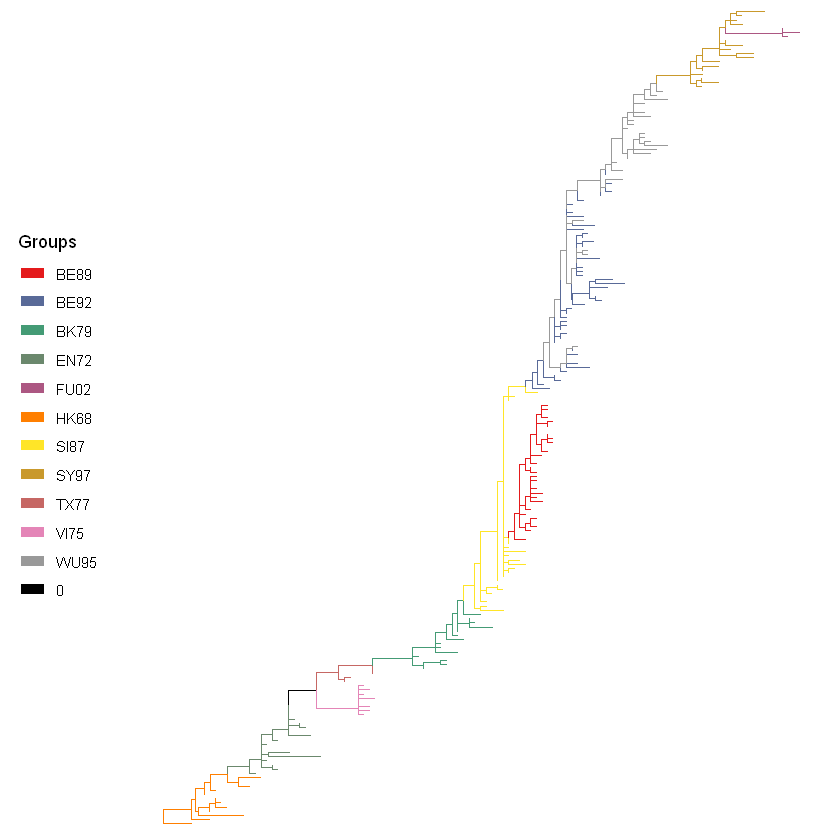

In [7]:
group <- split(rownames(clusterInfo), clusterInfo[["cluster"]])

groupColors <- colorRampPalette(brewer.pal(9, "Set1"))(length(group))
names(groupColors) <- names(group)
groupColors["0"] <- "black"

p <- ggtree(groupOTU(tree, group, group_name = "color"), aes(color = color)) +
    scale_color_manual(values = as.list(groupColors), limits = names(groupColors)) +
    guides(
      color = guide_legend(
        override.aes = list(size = 3),
        title = 'Groups'
      )
    ) +
    theme(legend.position = "left")
p
ggsave(filename = file.path(plotOutDir, "Smith2004_tree.pdf"), plot = p, width = 10, height = 8)

In [8]:
transMut <- list()

for (sp in mutations) {
    site <- attr(sp, "site")
    for (mp in sp) {
        for (i in seq_along(mp)[-1]) {
            prevTips <- mp[[i - 1]]
            currTips <- mp[[i]]
            prevAA <- attr(prevTips, "AA")
            currAA <- attr(currTips, "AA")
            mutation <- paste0(prevAA, site, currAA)
            prevCluster <- unique(clusterInfo[tree[["tip.label"]][prevTips], ])
            currCluster <- unique(clusterInfo[tree[["tip.label"]][currTips], ])
            for (prev in prevCluster) {
                for (curr in currCluster) {
                    trans <- paste(prev, curr, sep = "-")
                    if (trans %in% names(clusterSites)) {
                        if (trans %in% names(transMut)) {
                            transMut[[trans]] <- c(transMut[[trans]], mutation)
                        } else {
                            transMut[[trans]] <- mutation
                        }
                    }
                }
            }
        }
    }
}

In [9]:
smith <- lapply(strsplit(names(clusterSites), '-'), function(i) {
    n <- paste(i, collapse = '-')
    data.frame(
        "mutation" = clusterSites[[n]],
        "from" = rep(i[1], length(clusterSites[[n]])),
        "to" = rep(i[2], length(clusterSites[[n]]))
    )
})
smith <- do.call(rbind, smith)
write.csv(smith, file.path(plotOutDir, "Smith.csv"), row.names = FALSE)

Warning message:
"`mutate_()` is deprecated as of dplyr 0.7.0.
Please use `mutate()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


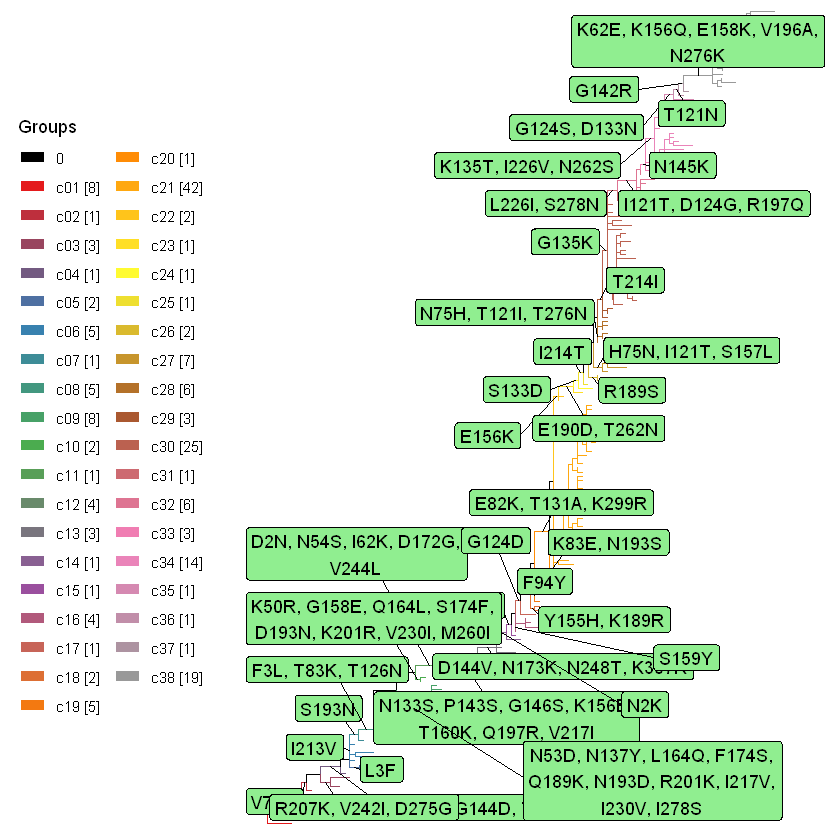

In [10]:
plot(mutations)

In [11]:
pred <- as.data.frame(mutations)
write.csv(pred, file.path(plotOutDir, "sitePath.csv"), row.names = FALSE)

### 2. H1N1 HA

In [12]:
tree <- read.tree(file.path(TREES_DIR, H1N1_HA_NAME, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- drop.tip(tree, "MK615591")
tree <- addMSA(tree, msaPath = file.path(TREES_DIR, H1N1_HA_NAME, "aligned.fasta"), msaFormat = "fasta")
nTip <- Ntip(tree)

In [13]:
paths <- lineagePath(tree, similarity = 0.01)

In [14]:
align <- attr(paths, "align")
reference <- attr(paths, "reference")

In [15]:
fixationSites <- readLines(file.path(VALIDATION_DIR, "sites.txt"))
fixationSites <- as.integer(fixationSites)

loci <- which(vapply(
    X = seq_along(reference),
    FUN = function(s) {
        length(unique(substr(align, s, s))) > 1
    },
    FUN.VALUE = logical(1)
))

siteCategory <- data.frame(
    "site" = integer(),
    "category" = character(),
    "fixationSite" = logical()
)
siteCategory <- rbind(
    siteCategory,
    data.frame(
        "site" = fixationSites,
        "category" = rep("fixed", length(fixationSites)),
        "fixationSite" = rep(TRUE, length(fixationSites))
    )
)

conservedSites <- setdiff(loci, fixationSites)
siteCategory <- rbind(
    siteCategory,
    data.frame(
        "site" = conservedSites,
        "category" = rep("conserved", length(conservedSites)),
        "fixationSite" = rep(FALSE, length(conservedSites))
    )
)
siteCategory <- siteCategory[order(siteCategory[["site"]]), ]
row.names(siteCategory) <- NULL

nPositive <- sum(siteCategory[["fixationSite"]] == TRUE)
nNegative <- sum(siteCategory[["fixationSite"]] == FALSE)

### 2.1. similarity

Test the `similarity` parameter in `fixationSites` function.

In [16]:
testParam <- "similarity"
plotOutDir <- file.path(PLOTS_DIR, testParam)
dir.create(plotOutDir, showWarnings = FALSE)

In [17]:
res <- readRDS(file.path(VALIDATION_DIR, paste0(testParam, ".rds")))

In [18]:
predResult <- data.frame(
    "similarity" = double(),
    "minEffectiveSize" = integer(),
    "rate" = double(),
    "category" = character()
)

for (similarity in names(res)) {
    for (minEffectiveSize in names(res[[similarity]])) {
        mutations <- res[[similarity]][[minEffectiveSize]]
        assessTable <- siteCategory
        sites <- as.integer(names(mutations))
        assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
        x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
        senstivity <- length(which(x == 2)) / nPositive
        specificity <- length(which(x == 0)) / nNegative
        
#         percentage <- as.integer(minEffectiveSize) / nTip
        predResult <- rbind(
            predResult,
            data.frame(
                "similarity" = as.double(c(similarity, similarity)),
                "minEffectiveSize" = as.integer(c(minEffectiveSize, minEffectiveSize)),
                "rate" = c(senstivity, specificity),
                "category" = c("Senstivity", "Specificity")
            )
        )
    }
}

predResult <- predResult[which(predResult[["minEffectiveSize"]] == 30), ]

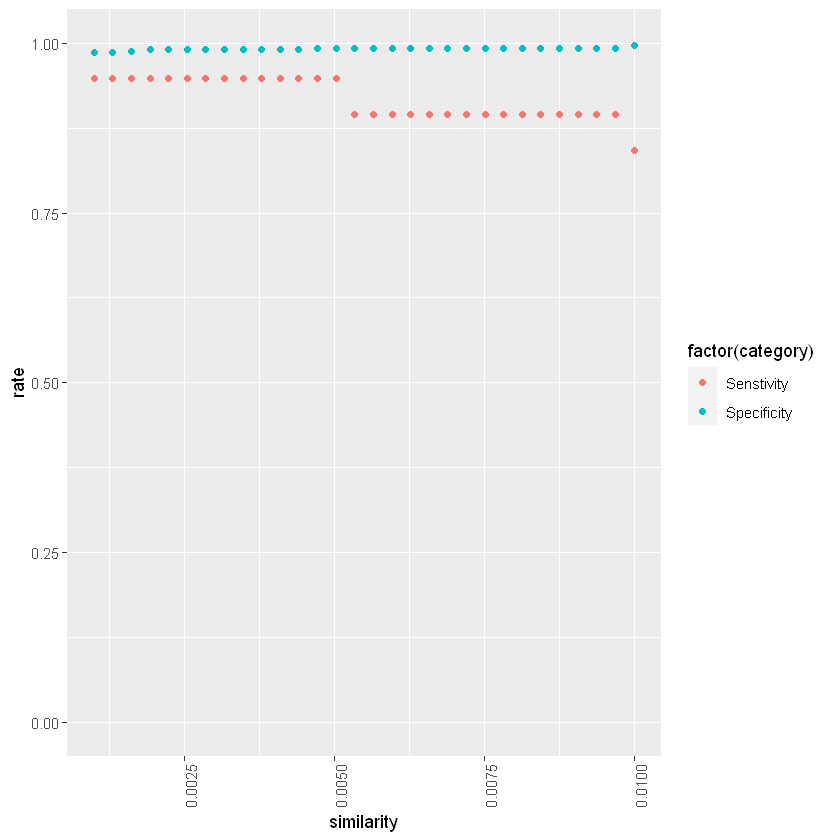

In [19]:
p <- ggplot(predResult, aes(similarity, rate)) +
    geom_point(aes(color = factor(category))) + ylim(0, 1) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
p

ggsave(
    filename = file.path(plotOutDir, paste0(testParam, ".pdf")),
    plot = p,
    device = "pdf",
    width = 3.25, height = 2
)

In [20]:
predResult <- data.frame(
    "site" = integer(),
    "fixationSite" = logical(),
    "predFixed" = logical(),
#     "minEffectiveSize" = integer(),
    "similarity" = double()
)

for (similarity in names(res)) {
    s <- as.double(similarity)
    for (minEffectiveSize in names(res[[similarity]])) {
        m <- as.integer(minEffectiveSize)
        if (m == 30) {
            mutations <- res[[similarity]][[minEffectiveSize]]
            predSites <- as.integer(names(mutations))
            assessTable <- siteCategory[, c("site", "fixationSite")]
            assessTable[["predFixed"]] <- assessTable[["site"]] %in% predSites
            assessTable <- assessTable[which(assessTable[["fixationSite"]] | assessTable[["predFixed"]]), ]
#             assessTable[["minEffectiveSize"]] <- m
            assessTable[["similarity"]] <- s
            predResult <- rbind(predResult, assessTable)
        }
    }
}

In [21]:
write.csv(predResult, file.path(plotOutDir, paste0(testParam, ".csv")), row.names = FALSE)

### 2.2. minEffectiveSize

Test the `minEffectiveSize` parameter in `fixationSites` function.

In [22]:
testParam <- "minEffectiveSize"
plotOutDir <- file.path(PLOTS_DIR, testParam)
dir.create(plotOutDir, showWarnings = FALSE)

In [23]:
res <- readRDS(file.path(VALIDATION_DIR, paste0(testParam, ".rds")))

In [24]:
predResult <- data.frame(
    "similarity" = double(),
    "minEffectiveSize" = integer(),
    "rate" = double(),
    "category" = character()
)

for (similarity in names(res)) {
    for (minEffectiveSize in names(res[[similarity]])) {
        mutations <- res[[similarity]][[minEffectiveSize]]
        assessTable <- siteCategory
        sites <- as.integer(names(mutations))
        assessTable[["predFixed"]] <- assessTable[["site"]] %in% sites
        x <- assessTable[["fixationSite"]] + assessTable[["predFixed"]]
        senstivity <- length(which(x == 2)) / nPositive
        specificity <- length(which(x == 0)) / nNegative
        
        percentage <- as.integer(minEffectiveSize) / nTip
        predResult <- rbind(
            predResult,
            data.frame(
                "similarity" = as.double(c(similarity, similarity)),
                "minEffectiveSize" = c(percentage, percentage),
                "rate" = c(senstivity, specificity),
                "category" = c("Senstivity", "Specificity")
            )
        )
    }
}
predResult <- predResult[which(predResult[["similarity"]] == 0.001), ]

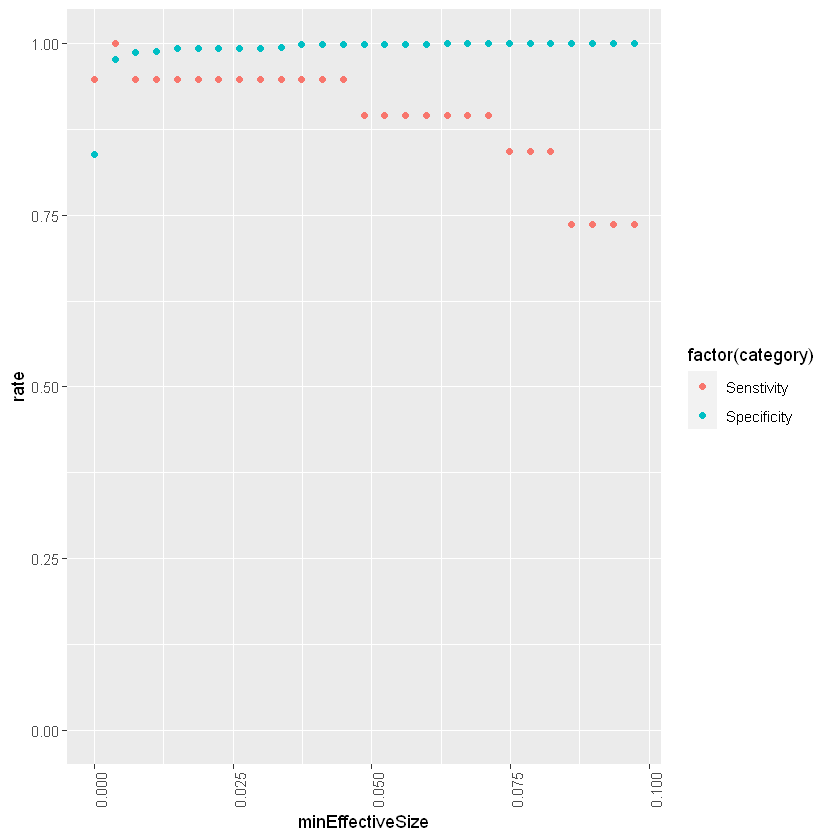

In [25]:
p <- ggplot(predResult, aes(minEffectiveSize, rate)) +
    geom_point(aes(color = factor(category))) + ylim(0, 1) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
p

ggsave(
    filename = file.path(plotOutDir, paste0(testParam, ".pdf")),
    plot = p,
    device = "pdf",
    width = 3.25, height = 2
)

In [26]:
predResult <- data.frame(
    "site" = integer(),
    "fixationSite" = logical(),
    "predFixed" = logical(),
    "minEffectiveSize" = integer()
#     "similarity" = double()
)

for (similarity in names(res)) {
    s <- as.double(similarity)
    for (minEffectiveSize in names(res[[similarity]])) {
        m <- as.integer(minEffectiveSize)
        if (s == 0.001) {
            mutations <- res[[similarity]][[minEffectiveSize]]
            predSites <- as.integer(names(mutations))
            assessTable <- siteCategory[, c("site", "fixationSite")]
            assessTable[["predFixed"]] <- assessTable[["site"]] %in% predSites
            assessTable <- assessTable[which(assessTable[["fixationSite"]] | assessTable[["predFixed"]]), ]
            assessTable[["minEffectiveSize"]] <- m / nTip
#             assessTable[["similarity"]] <- s
            predResult <- rbind(predResult, assessTable)
        }
    }
}

In [27]:
write.csv(predResult, file.path(plotOutDir, paste0(testParam, ".csv")), row.names = FALSE)